# Recreation of Figure 5 
Co-hosting probabilities $p_h(x)$ as a function of the hyperbolic distance x between TLD+1 nodes. 

### 1. Load the file with the node pairs that share IP.

In [1]:
# Read the pairs with shared IPs

plotName = "SameIPs"

pos_links = set()

same_ip_f_name = "co-hosting_list.txt"

with open(same_ip_f_name, "r") as fp:
    for l in fp.readlines():
        l = l.strip().split(" ")[0]
        pos_links.add(l)

print("# of pairs with shared IP: {}".format(len(pos_links)))

# of pairs with shared IP: 1181


### 2. Load the nodes coordinates file.

In [2]:
import re

# The Legal-entities network with the nodes coordinates 
f_name = "../Datasets/EdgeList_Legal_Entities.inf_coord"

header_map = {
    "Vertex": "id",
    "Inf.Kappa": "kappa",
    "Inf.Theta": "theta_rad",
    "Inf.Hyp.Rad.": "r"
}

# The final dataset
dataset = {}
# The output header variables
header = []
# The network nodes 
nodes = []
# The embedding parameters
parameters = {}

# Read the Mercator output file line by line
with open(f_name, "r") as fp:
    for l in fp.readlines():
        # Line cleanup step
        line = re.sub(' +', ' ', l.strip())
        # Process Comment line
        if line.startswith("#"):
            # Extract parameters
            if " - " in line:
                tmp = line.replace("# - ", "").split(": ")
                parameters[tmp[0]] = float(tmp[1])
            # Extract data header
            elif line.startswith("# Vertex"):
                tmp = line.replace("# ", "").split(" ")
                for e in tmp:
                    header.append(header_map[e])
        else: # Process nodes data
            tmp = line.split(" ")
            t = {}
            for k, v in zip(header, tmp):
                if k in ["theta_rad", "r", "kappa"]:
                    t[k] = float(v)
                else:
                    t[k] = v
            nodes.append(t)

dataset["parameters"] = parameters
dataset["nodes"] = nodes

print("# of nodes: {}".format(len(dataset["nodes"])))

# of nodes: 1215


In [3]:
# Dictionary to hold the nodes' attributes, theta ("t") and radius ("r").
NDict = {}

# Loop through all nodes and cast their attributes from string to float.
for n in dataset["nodes"]:
    # Cast string values into float
    NDict[n["id"]] = {
        "t": n["theta_rad"],
        "r": n["r"]
    }

# Get all node ids to create all possible links between them.
all_n_ids = NDict.keys()

print("# of node ids: {}".format(len(all_n_ids)))

# of node ids: 1215


### 3. Prepare all node combinations and estimate the hyperbolic distance between them. 

In [4]:
import math
import itertools

# Function to calculate the hyperbolic distance between two nodes
def distance(i, j):
    ti = i["t"]
    tj = j["t"]
    ri = i["r"]
    rj = j["r"]
    t_ij = math.pi - abs(math.pi - abs(ti - tj))
    return math.acosh( math.cosh(ri) * math.cosh(rj) - math.sinh(ri) * math.sinh(rj) * math.cos(t_ij) )

# Variable to hold the distance between all node combinations
Comb = {}


for i, j in itertools.combinations(all_n_ids, 2):
    dist = distance(NDict[i], NDict[j])
    Comb[i + "<->" + j] = dist
    
print("All link combinations: {}".format(len(Comb)))

All link combinations: 737505


In [5]:
# Make sure we have all links for each direction, that is A -> B or B -> A
new_pos_links = []

found = 0
not_found = 0

for p in pos_links:
    #print(p)
    if p in Comb:
        new_pos_links.append(p)
        found += 1
    else:
        t = p.split("<->")
        nt = t[1] + "<->" + t[0]
        #print(t, nt)
        if nt in Comb:
            new_pos_links.append(nt)
            found += 1
        else:
            not_found += 1
            
pos_links = new_pos_links

# Check that we found all pairs that share IP
print("Found: {:>7}\nNot fount: {:>3}\nCheck: {:>7}".format(found, not_found, found + not_found))

Found:    1181
Not fount:   0
Check:    1181


### 4. Estimate Hyperbolic Distance

In [6]:
import operator

# Assigned nodes to bins based on their hyperbolic distance.
def create_bins(combinations, step, debug=False):
    # First we sort all pairs based on their hyperbolic distance
    sorted_dist = sorted(combinations.items(), key=operator.itemgetter(1), reverse=True)
    s_f = sorted_dist.copy()

    # Variables to allow us to assign nodes to different hyperbolic distance bins
    bin_min = 0
    bin_max = step
    counter = 0
    bin = str(bin_max)
    # To hold the final pairs in each bin
    res = {}
    # Initialize the first bin
    res[bin] = []

    N = s_f.pop()
    while len(s_f) != 0:
        dist = N[1]
        if dist >= bin_max:
            if debug: print(bin, counter, len(res[bin]), N)
            bin_min = bin_max
            bin_max += step
            counter = 0
            bin = str(bin_max)
        if bin not in res:
            res[bin] = []
        if dist <= bin_max and dist >= bin_min:
            res[bin].append(N)
            N = s_f.pop()
            counter += 1

    # To handle the last node N from s_f.pop() above. 
    while True:
        dist = N[1]
        if dist >= bin_max:
            if debug: print(bin, counter, len(res[bin]), N)
            bin_min = bin_max
            bin_max += step
            counter = 0
            bin = str(bin_max)
        if bin not in res:
            res[bin] = []
        if dist <= bin_max and dist >= bin_min:
            res[bin].append(N)
            counter += 1
            break
    if debug: print(bin, counter, len(res[bin]), N)
    return res

# Estimate the merge probability per bin and return the plot data
def create_plot_data(bins, org_map, debug=False):
    labels = []
    props = []
    pos_counter = 0

    for b in bins:
        z = len(bins[b])
        m = 0
        for c in bins[b]:
            t = c[0].split("<->")
            src = t[0]
            dst = t[1]
            label = src + "<->" + dst
            if label in pos_links or dst + "<->" + src in pos_links:
                m += 1
            pos_counter += 1
    
        m_z = 0

        # Estimate the merge probability
        if z != 0:
            m_z = m/z

        if debug: print(b, z, m, m_z)
        if z > 0: # Exclude bins with no observations
            labels.append(b)
            props.append(m_z)
        else:
            labels.append(b)
            props.append(None)
    return labels, props
    

In [7]:
# Define the hyperbolic distance binning step
STEP = 3

In [8]:
import operator

sorted_dist = sorted(Comb.items(), key=operator.itemgetter(1), reverse=True)
print("# of pairs: {}".format(len(sorted_dist)))

# of pairs: 737505


In [9]:
# Assigned nodes to bins based on their hyperbolic distance.
BINS = create_bins(combinations=Comb, step=STEP, debug=False)
print("# of bins: {}".format(len(BINS)))

# of bins: 27


In [10]:
# Prepare data for plotting
labels, props = create_plot_data(bins=BINS, org_map=pos_links, debug=False)
print("# of labels: {}\n# of props: {}".format(len(labels), len(props)))

# of labels: 27
# of props: 27


In [11]:
# Discriminatory Power
merged_seen = len(pos_links)
ALL_PAIRS = set(Comb.keys())
disc_power = merged_seen/len(ALL_PAIRS)
print("Discriminatory Power: {}\nBaseline Probability: {}".format(disc_power, merged_seen/len(ALL_PAIRS)*100))

Discriminatory Power: 0.001601345075626606
Baseline Probability: 0.1601345075626606


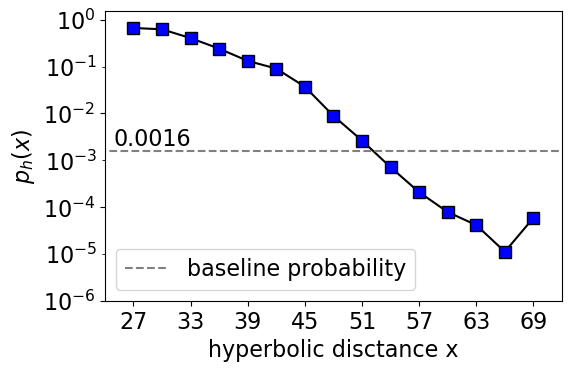

In [13]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib.ticker import MaxNLocator

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

pp = PdfPages("SharedIP_probability_Step_" + str(STEP) + ".pdf")

fig, ax1 = plt.subplots(figsize=(6, 4), dpi=100)
xs = np.arange(len(labels))
disc_power_l = [disc_power for x in labels]
np_props = np.array(props).astype(np.double)
masks = np.isfinite(np_props)

ax1.set_xlabel('hyperbolic disctance x')
ax1.set_ylabel('$p_h(x)$')
ax1.plot(xs[masks][:-4],  np_props[masks][:-4], 'ks-',  markersize=8, markerfacecolor="b", markeredgewidth=1.0, markeredgecolor="black", color="black")

ax1.plot(np.arange(len(labels)),  disc_power_l, linestyle='--', color='grey', label = 'baseline probability')
ax1.text(disc_power+7.3, disc_power+0.0004, "{:.4f}".format(disc_power), transform=ax1.transData)

ax1.tick_params(axis='y')
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels)
ax1.tick_params(axis='x', labelrotation = 0)
ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))

plt.legend()
plt.yscale('log')
ax1.set_ylim([0.000001, 1.5])
ax1.set_xlim([7, 23])
ax1.set_yticks([1, 0.1, 0.001, 0.0001, 0.00001, 0.000001], minor=True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(pp, format='pdf')
pp.close()